<a id="top"></a>
# NDVI Phenology
<hr>

# Notebook Summary

* LANDSAT 7, LANDSAT 8, or both are used to detect changes in plant life over time.

<hr>

# Algorithmic process  

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Maximum Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents) (selecting too much can make the acquisition process slow)
* [Load Data from the Data Cube](#retrieve_data)
* [Calculate NDVI](#calculate)
* [Examine the Selected Area](#area_analysis)
* [Create a Max NDVI Composite](#mosaic)
* [Export the Mosaic to a PNG and a GeoTIFF](#export)

<hr>

# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between the amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The intention is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy. When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller, which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.5-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam
21,LANDSAT_7,ls7_level1_usgs


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
23,LANDSAT_8,ls8_l1_pc_usgs
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania
20,LANDSAT_8,ls8_level1_usgs


In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = True
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

## <span id="extents">Get the Maximum Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map

min_max_dates = np.empty((len(platforms), 2), dtype=object)
min_max_lat = np.empty((len(platforms), 2))
min_max_lon = np.empty((len(platforms), 2))
for i, (platform, product) in enumerate(zip(platforms, products)):
    # Get the extents of the cube
    descriptor = api.get_query_metadata(platform=platform, product=product, measurements=[])

    # Save extents
    min_max_dates[i] = descriptor['time_extents']
    min_max_lat[i] = descriptor['lat_extents']
    min_max_lon[i] = descriptor['lon_extents']
    
# Determine minimum and maximum longitudes that bound a common area among products
min_lon = np.max(min_max_lon[:,0]) # The greatest minimum longitude among products
max_lon = np.min(min_max_lon[:,1]) # The smallest maximum longitude among products
min_lat = np.max(min_max_lat[:,0])
max_lat = np.min(min_max_lat[:,1])
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:184: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

**Specify start and end dates in the same order as platforms and products**

In [7]:
# Use these four lines to select the time slice common to all products.
# min_start_date_mutual = np.max(min_max_dates[:,0])
# max_end_date_mutual = np.min(min_max_dates[:,1])
# start_dates = [min_start_date_mutual, min_start_date_mutual]
# end_dates = [max_end_date_mutual, max_end_date_mutual]
# Use these two lines to select all data available to each product.
# start_dates = min_max_dates[:,0]
# end_dates = min_max_dates[:,1]
# Select a subset of the time available.
# start_date = dt.datetime(2016,1,1)
# end_date = dt.datetime(2017,12,1)
start_date = dt.datetime(2016,1,1)#(dt.datetime(2016,1,1), dt.datetime(2016,1,1))
end_date = dt.datetime(2017,12,1)#(dt.datetime(2017,12,1), dt.datetime(2017,12,1))

**Specify an area to analyze**

In [8]:
# Specify latitude and longitude bounds of an interesting area within the full extents

# Ghana
# min_lat_small, max_lat_small = (5.7261, 5.7390) # Crops NW of Accra (small)
# min_lon_small, max_lon_small = (-0.4960, -0.4889) # Crops NW of Accra (small)
# min_lat_small, max_lat_small = (5.7259, 5.7517) # Crops NW of Accra (medium)
# min_lon_small, max_lon_small = (-0.5308, -0.5143) # Crops NW of Accra (medium)
min_lat_small, max_lat_small = (8.0074, 8.0203) # Central Ghana - West of Kintampo
min_lon_small, max_lon_small = (-2.0486, -2.0332) # Central Ghana - West of Kintampo
    
# Vietnam
# min_lat_small, max_lat_small = (10.95, 11.00) # Area #1
# min_lon_small, max_lon_small = (107.15, 107.20) # Area #1
# min_lat_small_area, max_lat_small_area = (11.10, 11.39) # Area #2
# min_lon_small_area, max_lon_small_area = (106.8, 106.92) # Area #2

**Visualize the selected area**

In [9]:
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

## <span id="retrieve_data">Load Data from the Data Cube [&#9652;](#top)</span>

In [10]:
from utils.data_cube_utilities.dc_load import load_multiplatform

measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset, clean_mask, _ = \
    load_multiplatform(dc, platforms, products, 
                       load_params=dict(lat=lat_small, lon=lon_small, time=(start_date, end_date),
                                        measurements=measurements))
cleaned_dataset = dataset.where(clean_mask)
del dataset

## <span id='calculate'>Calculate NDVI [&#9652;](#top)</span>

In [11]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
ndvi_arr = NDVI(cleaned_dataset)
cleaned_dataset['ndvi'] = ndvi_arr

## <span id="area_analysis">Examine the Selected Area [&#9652;](#top)</span>

**If no plots appear in the figures below, there is no data available for the region selected**

**Box-and-Whisker Plot by Full Time Period, Week, Month, Week of Year, or Month of Year.**

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/xarray-0.10.9-py3.6.egg/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


NDVI (Aggregated by Month of Year)


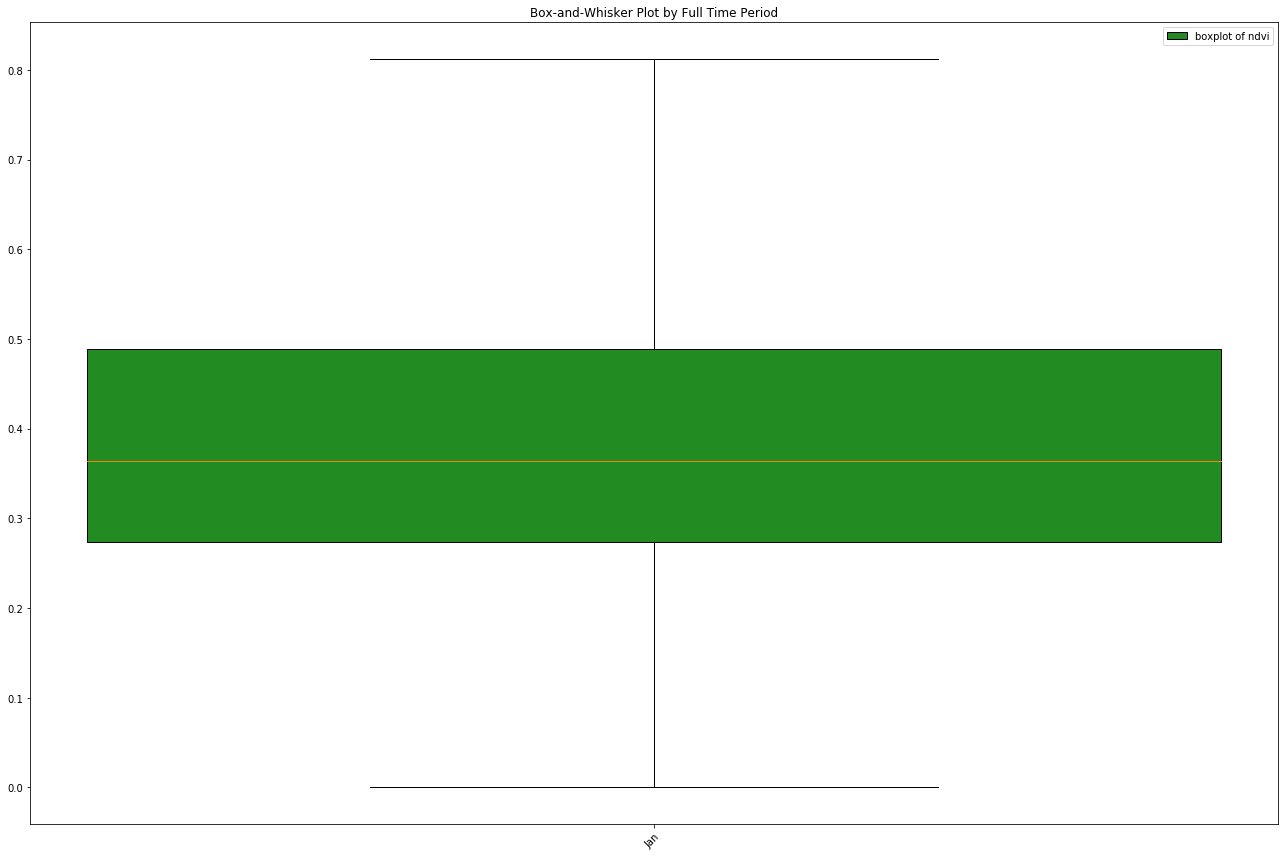

In [12]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a Gaussian curve fit of the mean of NDVI along time.
plot_gaussian_filter_ndvi_mean = True
max_times_per_plot = 10 # The maximum number of acquisitions with data that appear in each plot.

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
for bin_by in ['monthofyear']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').mean()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').mean()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={'ndvi':{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_gaussian_filter_ndvi_mean:
    params['plot_descs']['ndvi']['mean'] = [{'poly': {'degree': 3}}]
    
params['scale_params'] = 'norm'
    
xarray_time_series_plot(**params)
plt.title('Box-and-Whisker Plot by Full Time Period')
print("NDVI {}".format("(Aggregated by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))

## <span id="mosaic">Create a Max NDVI Composite [&#9652;](#top)</span>

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/dc_utilities.py:214: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for band in dataset:


(<Figure size 720x852.245 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5490883cc0>)

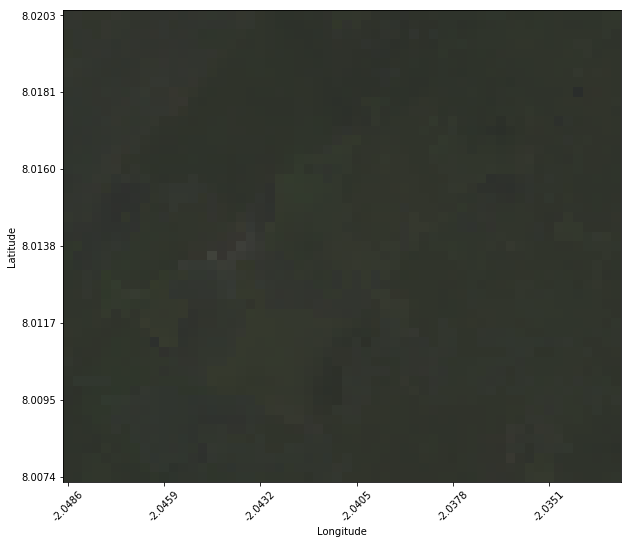

In [13]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
from utils.data_cube_utilities.dc_rgb import rgb
max_ndvi_mosaic = create_max_ndvi_mosaic(cleaned_dataset, clean_mask)
rgb(max_ndvi_mosaic)

## <span id="export">Export the Mosaic to a PNG and a GeoTIFF [&#9652;](#top)</span>

**Export to PNG**

In [14]:
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
import os
png_dir = 'output/pngs'
if not os.path.exists(png_dir):
    os.makedirs(png_dir)
write_png_from_xr('{}/NDVI_Phenology_Max_NDVI_Mosaic.png'.format(png_dir), max_ndvi_mosaic, ['red','green','blue'], scale=(0,4000))

**Export to GeoTIFF**

In [15]:
from utils.data_cube_utilities.import_export import export_xarray_to_geotiff
geotiff_dir = 'output/geotiffs/NDVI_Phenology'
if not os.path.exists(geotiff_dir):
    os.makedirs(geotiff_dir)
export_xarray_to_geotiff(cleaned_dataset, "{}/NDVI_Phenology".format(geotiff_dir))